In [1]:
import sys
import os
import math
import random
import heapq 
import numpy as np
import pandas as pd
from PIL import Image
import psycopg2 as ps
from io import StringIO,BytesIO 
import pywt
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [4]:
#Experiment: imgsmlr https://github.com/postgrespro/imgsmlr
#create table and import images with Binary
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="asoct")#connect postgresql 
if conn is not None:
    cur = conn.cursor()
    #create table
    command = "create table cataract (name text NOT NULL, content bytea NOT NULL);"#create table cataract
    cur.execute(command)
    conn.commit()# commit the changes
    
    #insert images
    image_dir = '/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New' #the path of images
    for fname in sorted(os.listdir(image_dir)):
        if fname.endswith(".jpg"):
            with open(os.path.join(image_dir, fname),'rb') as reader:#open the image file 
                    img_buffer = reader.read()     
            command = "insert into cataract(name, content) values(%s, %s);"#create table cataract
            params = (fname, ps.Binary(img_buffer))
            cur.execute(command, params)
            conn.commit()# commit the changes  
    cur.close()# close communication with the PostgreSQL database server
conn.close()#close connect with database server

C020_20180514_100234_R_CASIA2_LGC_002.jpg


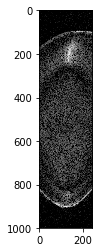

In [4]:
#query and show image
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="asoct")#connect postgresql 
if conn is not None:
    cur = conn.cursor() 
    command = "select * from cataract limit 1;"
    cur.execute(command)    
    rcd = cur.fetchone()
    img_name = rcd[0]#get name
    img_data = rcd[1]#get content
    print (img_name)
    img = Image.open(BytesIO(img_data))
    #img.save(img_name)
    #img.show()
    plt.imshow(img)
    cur.close()
conn.close()

In [7]:
#performance metric
data = pd.read_csv("/data/fjsdata/ASOCT/Cataract/CBIR_Cataract.csv" , sep=',')#load dataset
print('Dataset Statistics: Rows = %d, Cols = %d' % (data.shape[0], data.shape[1]))
#labels_dis = data[['D']].drop_duplicates()#observe the distribution of labels
#load images
name_list = data['A'].tolist()
def hit(name, smname):
    if smname not in name_list:#no label
        return 0
    else:
        lv_name = data.loc[data.A==name,'D'].values[0]
        lv_smname = data.loc[data.A==smname,'D'].values[0]
        if ( lv_name== lv_smname): #same level,hit
            return 1
        return 0  

conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="asoct")#connect postgresql 
if conn is not None:
    cur = conn.cursor() 
    for topk in [5,10,15]:
        HR =[]
        for name in random.sample(name_list,1000):
            command = "SELECT name, smlr FROM ( SELECT name, pattern <-> (SELECT pattern FROM pat WHERE name = %s) AS smlr FROM pat WHERE name <> %s ORDER BY signature <-> (SELECT signature FROM pat WHERE name = %s) LIMIT 100) x ORDER BY x.smlr ASC LIMIT %s;"
            params = (name, name, name, topk)
            cur.execute(command, params)
            #perfromance 
            for smname, smlr in cur.fetchall():
                HR.append(hit(name,smname))
        print("HR@{}={}".format(topk,np.mean(HR)))              
    cur.close()
conn.close()

Dataset Statistics: Rows = 31998, Cols = 4
HR@5=0.9582
HR@10=0.8859
HR@15=0.7871333333333334


In [24]:
#performance metric
data = pd.read_csv("/data/fjsdata/ASOCT/Cataract/CBIR_Cataract.csv" , sep=',')#load dataset
print('Dataset Statistics: Rows = %d, Cols = %d' % (data.shape[0], data.shape[1]))
#labels_dis = data[['D']].drop_duplicates()#observe the distribution of labels
#load images
name_list = data['A'].tolist()
def hit(name, smname):
    if smname not in name_list:#no label
        return 0
    else:
        lv_name = data.loc[data.A==name,'D'].values[0]
        lv_smname = data.loc[data.A==smname,'D'].values[0]
        if ( lv_name== lv_smname): #same level,hit
            return 1
        return 0  
    
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="asoct")#connect postgresql 
if conn is not None:
    cur = conn.cursor() 
    for topk in [5,10,15]:
        HR =[] #Hit ratio 
        MAP =[] #mean average precision
        NDCG = []#Normalized Discounted Cumulative Gain
        for name in random.sample(name_list,1000):
            command = "SELECT name, smlr FROM ( SELECT name, pattern <-> (SELECT pattern FROM pat WHERE name = %s) AS smlr FROM pat WHERE name <> %s ORDER BY signature <-> (SELECT signature FROM pat WHERE name = %s) LIMIT 100) x ORDER BY x.smlr ASC LIMIT %s;"
            params = (name, name, name, topk)
            cur.execute(command, params)
            #perfromance
            pos_len = 0
            rank_len = 0
            rank_map = []
            for smname, smlr in cur.fetchall():
                ret = hit(name,smname)
                HR.append(ret)
                rank_len=rank_len+1
                if ret==1: 
                    pos_len = pos_len +1
                    rank_map.append(pos_len/rank_len) 
                    IDCG=math.log(2) / math.log(pos_len+2)
                    DCG=math.log(2) / math.log(rank_len+2)
                    NDCG.append(DCG/IDCG)
                else: 
                    rank_map.append(0)                  
            MAP.append(np.mean(rank_map))  
        print("HR@{}={:.6f}, MAP@{}={:.6f}, NDCG@{}={:.6f}".format(topk,np.mean(HR),topk,np.mean(MAP),topk,np.mean(NDCG)))              
    cur.close()
conn.close()

Dataset Statistics: Rows = 31998, Cols = 4
HR@5=0.951800, MAP@5=0.948653, NDCG@5=0.998598
HR@10=0.865500, MAP@10=0.852618, NDCG@10=0.993795
HR@15=0.790867, MAP@15=0.769620, NDCG@15=0.989489


In [3]:
#Experiment: extract features of images with Wavelet Tramsform
#create table
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="asoct")#connect postgresql 
if conn is not None:
    cur = conn.cursor()
    command = "create table cataract_wt (name text NOT NULL, cA_img float8[] NOT NULL, pca_img float8[] NOT NULL);"
    cur.execute(command)
    conn.commit()# commit the changes
    cur.close()# close communication with the PostgreSQL database server
conn.close()

In [25]:
#pca training
image_dir = '/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New' #the path of images
pca_X = []
pca = PCA(10)  #pca model with 100 dimensions
#count =0
for fname in sorted(os.listdir(image_dir)):
    #count = count +1
    #if count >100: break
    if fname.endswith(".jpg"):
        img = cv2.imread(os.path.join(image_dir, fname))#three chanells
        if img is not None:
            img = cv2.resize(img, (1000, 200))#resize image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
            pca_X.append(img.flatten())#compress to one dimensions 
        
pca.fit(pca_X)
#print(pca.transform(pca_X[:1]))

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [26]:
#Extract features with wavelet transform and stroed in db
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="asoct")#connect postgresql 
if conn is not None:
    cur = conn.cursor()
    image_dir = '/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New' #the path of images
    num_img = 0 #count
    for fname in sorted(os.listdir(image_dir)):
        if fname.endswith(".jpg"):
            img = cv2.imread(os.path.join(image_dir, fname))
            if img is not None:
                img = cv2.resize(img, (1000, 200))#resize image
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)  #turn  multi-channel to single-channel
                pca_img = pca.transform([img.flatten()])#dimension reduction
                #https://pywavelets.readthedocs.io/en/latest/regression/wavelet.html
                coeffs = pywt.dwt2(data=img, wavelet='haar')#Single level Discrete Wavelet Transform.
                #https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html
                cA, (cH, cV, cD) = coeffs #Approximation, horizontal detail, vertical detail and diagonal detail coefficients respectively.
                # concatenate and get a image
                #AH = np.concatenate([cA, cH], axis=1)
                #VD = np.concatenate([cV, cD], axis=1)
                #img = np.concatenate([AH, VD], axis=0) 
                command = "insert into cataract_wt(name, cA_img, pca_img) values(%s, %s, %s);"
                params = (fname, cA.flatten().tolist(), pca_img.flatten().tolist())
                cur.execute(command, params)
                conn.commit()# commit the changes   
        num_img = num_img+1
        sys.stdout.write('\r{} / {} '.format(num_img,40066))
        sys.stdout.flush()
    cur.close()
conn.close()

40066 / 40066 

In [13]:
#SIFT+KMean+VLAD+PCA
#https://github.com/Lithogenous/VLAD-SIFT-python/blob/master/vlad_raw.py
#hyperparameters
COLUMNOFCODEBOOK = 32
DESDIM = 128
SUBVEC = 32
SUBCLUSTER = 256
PCAD = 128
TESTTYPE = 0
def feature_extractor(file_path):
    '''
    Description: extract feature from given image
    Input: file_path - image path
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    detector = cv2.ORB_create(nfeatures=1000)
    img = cv2.imread(file_path)
    kp = detector.detect(img, None) #find the keypoint
    _, des = detector.compute(img, kp) #compute the descriptor

    return des


def sift_extractor(file_path):
    '''
    Description: extract \emph{sift} feature from given image
    Input: file_path - image path
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    img = cv2.imread(file_path)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=500)
    _,des = sift.detectAndCompute(gray,None) 

    return des

def get_cluster_center(des_set, K):
    '''
    Description: cluter using a default setting
    Input: des_set - cluster data
                 K - the number of cluster center
    Output: laber  - a np array of the nearest center for each cluster data
            center - a np array of the K cluster center
    '''
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)
    des_set = np.float32(des_set)
    ret, label, center = cv2.kmeans(des_set, K, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)
    return label, center


def get_des_vector(file_path_list):
    '''
    Description: get descriptors of all the images 
    Input: file_path_list - all images path
    Output:       all_des - a np array of all descriptors
            iamge_des_len - a list of number of the keypoints for each image 
    '''
    all_des = np.empty(shape=[0, DESDIM])
    image_des_len = []

    for eachFile in file_path_list:
        try:
            #des = feature_extractor(eachFile)
            des = sift_extractor(eachFile)
            all_des = np.concatenate([all_des, des])
            image_des_len.append(len(des))
            #print(eachFile)
        except:
            print(eachFile)
            #image_des_len.append(0)
            print("extract feature error")
    return all_des, image_des_len


def get_codebook(all_des, K):
    '''
    Description: train the codebook from all of the descriptors
    Input: all_des - training data for the codebook
                 K - the column of the codebook
    '''
    label, center = get_cluster_center(all_des, K)
    return label, center


def get_vlad_base(img_des_len, NNlabel, all_des, codebook):
    '''
    Description: get all images vlad vector 
    '''
    cursor = 0
    vlad_base = []
    for eachImage in img_des_len:
        descrips = all_des[cursor : cursor + eachImage]
        centriods_id = NNlabel[cursor : cursor + eachImage]
        centriods = codebook[centriods_id]
    
        vlad = np.zeros(shape=[COLUMNOFCODEBOOK, DESDIM])
        for eachDes in range(eachImage):
            vlad[centriods_id[eachDes]] = vlad[centriods_id[eachDes]] + descrips[eachDes] - centriods[eachDes]
        cursor += eachImage
    
        vlad_norm = vlad.copy()
        cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2)
        vlad_base.append(vlad_norm.reshape(COLUMNOFCODEBOOK * DESDIM, -1))

    return vlad_base


def get_vlad_base_pca(img_des_len, NNlabel, all_des, codebook):
    cursor = 0
    vlad_base = []
    for eachImage in img_des_len:
        descrips = all_des[cursor : cursor + eachImage]
        centriods_id = NNlabel[cursor : cursor + eachImage]
        centriods = codebook[centriods_id]
    
        vlad = np.zeros(shape=[COLUMNOFCODEBOOK, DESDIM])
        for eachDes in range(eachImage):
            vlad[centriods_id[eachDes]] = vlad[centriods_id[eachDes]] + descrips[eachDes] - centriods[eachDes]
        cursor += eachImage

        vlad_base.append(vlad.reshape(COLUMNOFCODEBOOK * DESDIM, -1))
    
    vlad_base_pca = np.array(vlad_base)
    vlad_base_pca = vlad_base_pca.reshape(-1, DESDIM * COLUMNOFCODEBOOK)
    sklearn_pca = sklearnPCA(n_components=PCAD)
    sklearn_transf = sklearn_pca.fit_transform(vlad_base_pca)
    sklearn_transf_norm = sklearn_transf.copy()
    for each, each_norm in zip(sklearn_transf, sklearn_transf_norm):
        cv2.normalize(each, each_norm, 1.0, 0.0, cv2.NORM_L2)
    return sklearn_transf_norm, sklearn_pca

def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors
    '''
    return np.linalg.norm(vec1 - vec2)


def get_pic_vlad(pic, des_size, codebook):
    '''
    Description: get the vlad vector of each image
    '''
    vlad = np.zeros(shape=[COLUMNOFCODEBOOK, DESDIM])
    for eachDes in range(des_size):
        des = pic[eachDes]
        min_dist = 1000000000.0
        ind = 0
        for i in range(COLUMNOFCODEBOOK):
            dist = cal_vec_dist(des, codebook[i])
            if dist < min_dist:
                min_dist = dist
                ind = i
        vlad[ind] = vlad[ind] + des - codebook[ind]
    
    vlad_norm = vlad.copy()
    cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2)
    vlad_norm = vlad_norm.reshape(COLUMNOFCODEBOOK * DESDIM, -1)
    
    return vlad_norm

def get_pic_vlad_pca(pic, des_size, codebook, sklearn_pca):
    vlad = np.zeros(shape=[COLUMNOFCODEBOOK, DESDIM])
    for eachDes in range(des_size):
        des = pic[eachDes]
        min_dist = 1000000000.0
        ind = 0
        for i in range(COLUMNOFCODEBOOK):
            dist = cal_vec_dist(des, codebook[i])
            if dist < min_dist:
                min_dist = dist
                ind = i
        vlad[ind] = vlad[ind] + des - codebook[ind]
    
    vlad = vlad.reshape(-1, COLUMNOFCODEBOOK * DESDIM)
    sklearn_transf = sklearn_pca.transform(vlad)
    sklearn_transf_norm = sklearn_transf.copy()
    cv2.normalize(sklearn_transf, sklearn_transf_norm, 1.0, 0.0, cv2.NORM_L2)
    
    return sklearn_transf_norm

def get_PQ_dist(vec1, vec2):
    vec1 = np.hsplit(vec1, SUBVEC)
    vec2 = np.hsplit(vec2, SUBVEC)
    dist = 0.0
    for sv1, sv2 in zip(vec1, vec2):
        dist += cal_vec_dist(sv1, sv2)
    return dist

def get_adc_dist(vec1, vec2):
    indexdist = float(sum(ret_adc_code[vec1] == label_list[vec2]))
    pqdist = get_PQ_dist(vlad_base_pca[vec2], ret_vlad_list[vec1])
    if indexdist <= 2:
        return pqdist / 3.0
    else:
        return pqdist / indexdist

In [ ]:
image_dir = '/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New' #the path of images
file_path_list = []
for fname in sorted(os.listdir(image_dir)):
    if fname.endswith(".jpg"):
        file_path_list.append(os.path.join(image_dir, fname))
all_des, image_des_len = get_des_vector(file_path_list)
NNlabel, codebook = get_codebook(all_des, COLUMNOFCODEBOOK)
vlad_base = get_vlad_base(image_des_len, NNlabel, all_des, codebook) #vlad only

#test
data = pd.read_csv("/data/fjsdata/ASOCT/Cataract/CBIR_Cataract.csv" , sep=',')#load dataset
print('Dataset Statistics: Rows = %d, Cols = %d' % (data.shape[0], data.shape[1]))
name_list = data['A'].tolist()
test_image_list = []
for name in random.sample(name_list,1000):    
    test_image_list.append(os.path.join(image_dir, name))
ret_des, ret_des_len = get_des_vector(test_image_list)    
##get all the vlad vectors of retrival set without pca dimensionality reduction
cursor_ret = 0
ret_vlad_list = []
for eachretpic in range(len(ret_des_len)):
    pic = ret_des[cursor_ret: cursor_ret + ret_des_len[eachretpic]]
    ret_vlad = get_pic_vlad(pic, ret_des_len[eachretpic], codebook)
    cursor_ret += ret_des_len[eachretpic]
    ret_vlad_list.append(ret_vlad)

def hit(name, smname):
    if smname not in name_list:#no label
        return 0
    else:
        lv_name = data.loc[data.A==name,'D'].values[0]
        lv_smname = data.loc[data.A==smname,'D'].values[0]
        if ( lv_name== lv_smname): #same level,hit
            return 1
        return 0  
    
for topk in [5,10,15]:
    HR =[] #Hit ratio 
    MAP =[] #mean average precision
    for i in range(len(ret_vlad_list)):
        dist_list = []
        test_name = test_image_list[i].split("/")[-1] #get test image name
        for eachpic in range(len(image_des_len)):
            dist = cal_vec_dist(ret_vlad_list[i], vlad_base[eachpic])
            dist_list.append(dist)
            most_sim = np.array(dist_list)
            pos_len = 0
            rank_len = 0
            rank_map = []
            #choose the topk nearest images of the given image 
            z = heapq.nsmallest(topk,most_sim)
            for i in range(topk):
                index = dist_list.index(z[i])
                name = file_path_list[index].split("/")[-1] #get similar image name
                ret = hit(name,smname)
                HR.append(ret)
                rank_len=rank_len+1
                if ret==1: 
                    pos_len = pos_len +1
                    rank_map.append(pos_len/rank_len) 
                else: 
                    rank_map.append(0)
            MAP.append(np.mean(rank_map))  
    print("HR@{}={:.6f}, MAP@{}={:.6f}".format(topk,np.mean(HR),topk,np.mean(MAP)))    

In [9]:
#performance analysis with SIFT
#https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html
#https://www.cnblogs.com/wangguchangqing/p/9590406.html?tdsourcetag=s_pcqq_aiomsg
#http://zhaoxuhui.top/blog/2018/05/18/OpenCV_Contrib.html
#pip install opencv-python==3.4.2.16
#pip install opencv-contrib-python==3.4.2.16
img1 = cv2.imread('/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/c0100_20181102_111708_R_CASIA2_LGC_002.jpg')
img2 = cv2.imread('/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100425_L_CASIA2_LGC_008.jpg')
gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1,None)
kp2, des2 = sift.detectAndCompute(gray2,None)
print (des1.shape)
print (des2.shape)
bf = cv2.BFMatcher()
    
matches = bf.knnMatch(des1, des2, k=2)#return top k matches
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        print([m])

(2936, 128)
(3098, 128)
[<DMatch 0x7f76983fe9d0>]
[<DMatch 0x7f76983e7410>]
[<DMatch 0x7f76983ea290>]
[<DMatch 0x7f76983ee990>]
[<DMatch 0x7f76983ee9d0>]
[<DMatch 0x7f76983f0550>]
[<DMatch 0x7f76983f3850>]


In [6]:
import sys
sys.path

['/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [64]:
import numpy as np
import pandas as pd

filePath = "/data/fjsdata/ASOCT/Cataract/train_img_level.csv" 
train_data = pd.read_csv(filePath, sep=',',header=None,names=['A', 'B','C','D'])
print (train_data.shape)
filePath = "/data/fjsdata/ASOCT/Cataract/test_img_level.csv" 
test_data = pd.read_csv(filePath, sep=',',header=None,names=['A', 'B','C','D'])
print (test_data.shape)
data = pd.concat([train_data,test_data])#concate according to row
data = data[data['D']!="?"]
print (data.shape)
print (data.head())
data.to_csv('/data/fjsdata/ASOCT/Cataract/CBIR_Cataract.csv',index=0)#default sep is ','

(22777, 4)
(9279, 4)
(31998, 4)
                                            A     B   C  D
0  c0100_20181102_111708_R_CASIA2_LGC_000.jpg  C100  OD  3
1  c0100_20181102_111708_R_CASIA2_LGC_002.jpg  C100  OD  3
2  c0100_20181102_111708_R_CASIA2_LGC_004.jpg  C100  OD  3
3  c0100_20181102_111708_R_CASIA2_LGC_006.jpg  C100  OD  3
4  c0100_20181102_111708_R_CASIA2_LGC_008.jpg  C100  OD  3
